In [275]:
# import the required Libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
from matplotlib.colors import Normalize
import matplotlib.patheffects as PathEffects

## Read the CSV File with Polygon Data

In [276]:
gdf  = pd.read_csv('Data\\2021_Federal_Census__Neighbourhoods_as_of_Official_Census_Day_20231228.csv')

## Clean up data and rename colums

In [277]:
# Rename columns
gdf.rename(columns={
    'the_geom': 'polygon_data',
    'descriptiv': 'neighbourhood_name',
    'neighbourh': 'neighbourhood_id',
    # Add other columns here as necessary
}, inplace=True)

# Clean up 'neighbourhood_name' by stripping leading and trailing spaces
gdf['neighbourhood_name'] = gdf['neighbourhood_name'].str.strip()

# Convert 'neighbourhood_id' to an integer
# Ensure the column doesn't contain non-numeric values before converting
gdf['neighbourhood_id'] = pd.to_numeric(gdf['neighbourhood_id'], errors='coerce').fillna(0).astype(int)

# Only keep required colums
gdf  = gdf[['polygon_data', 'neighbourhood_name', 'neighbourhood_id']]


## Convert the column "polygon_data" colum in the CSV to geometry type for geopandas

In [278]:
# Convert the 'polygon_data' column from WKT to actual geometry objects
gdf ['polygon_data'] = gdf ['polygon_data'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf , geometry='polygon_data')

## Load average and median age data

In [279]:
age_df = pd.read_csv('Data\\2021_Federal_Census__Average_and_Median_Age_20231228.csv')

## Merge the two data

In [280]:
# Merge the geographic data with the population data
merged_gdf = gdf.merge(age_df, left_on='neighbourhood_id', right_on='Neighbourhood Number')

## Filter the data

In [281]:
avg_age_gdf = merged_gdf[(merged_gdf['Gender'] == 'Total') & (merged_gdf['Characteristic'] == 'Average age of the population')].copy()

median_age_gdf = merged_gdf[(merged_gdf['Gender'] == 'Total') & (merged_gdf['Characteristic'] == 'Median age of the population')].copy()

## Define the fucntion to create a HeatMap

In [282]:
def create_heatmap(base_gdf, overlay_gdf, title, value_column, cmap='viridis'):
    
    base_gdf['number'] = base_gdf['neighbourhood_name'].factorize()[0] + 1
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    
    # Plot all polygons as a base layer
    base_gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

    # Normalize the value column for color mapping
    norm = Normalize(vmin=overlay_gdf[value_column].min(), vmax=overlay_gdf[value_column].max())
    
    # Plotting the overlay geometries with colors based on the value column
    overlay_gdf.plot(column=value_column, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='black', norm=norm)

    # Adding labels with the number for each neighborhood
    for x, y, number in zip(base_gdf.geometry.centroid.x, base_gdf.geometry.centroid.y, base_gdf['number']):
        ax.annotate(str(number), xy=(x, y), xytext=(3, 3), textcoords="offset points", 
                fontsize=4, color='white', weight='bold', 
                path_effects=[PathEffects.withStroke(linewidth=2, foreground="black")])

    # Create a color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []  # dummy array for the scalar mappable
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label("Age")

    # Setting title and axis off
    ax.set_title(title, fontsize=15)
    ax.axis('off')
    
    plt.show()

## Define the TOC Function

In [283]:
def create_toc_plot(base_gdf):
    # Prepare data for TOC
    toc_data = base_gdf[['number', 'neighbourhood_name']].drop_duplicates().sort_values(by='number')
    
    # Create a figure and single subplot
    fig, ax = plt.subplots(figsize=(10, len(toc_data)*0.25))  # Adjust the size as needed
    
    # Set up the table data
    cell_text = [row.tolist() for index, row in toc_data.iterrows()]
    
    # Create the table and adjust properties
    table = ax.table(cellText=cell_text, colLabels=['Number', 'Neighbourhood'], loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10) 
    table.scale(1.2, 1.2)  
    # Hide axes and frame
    ax.axis('off')
    ax.set_frame_on(False)
    
    plt.tight_layout()
    plt.show()

## Generate the Heatmaps

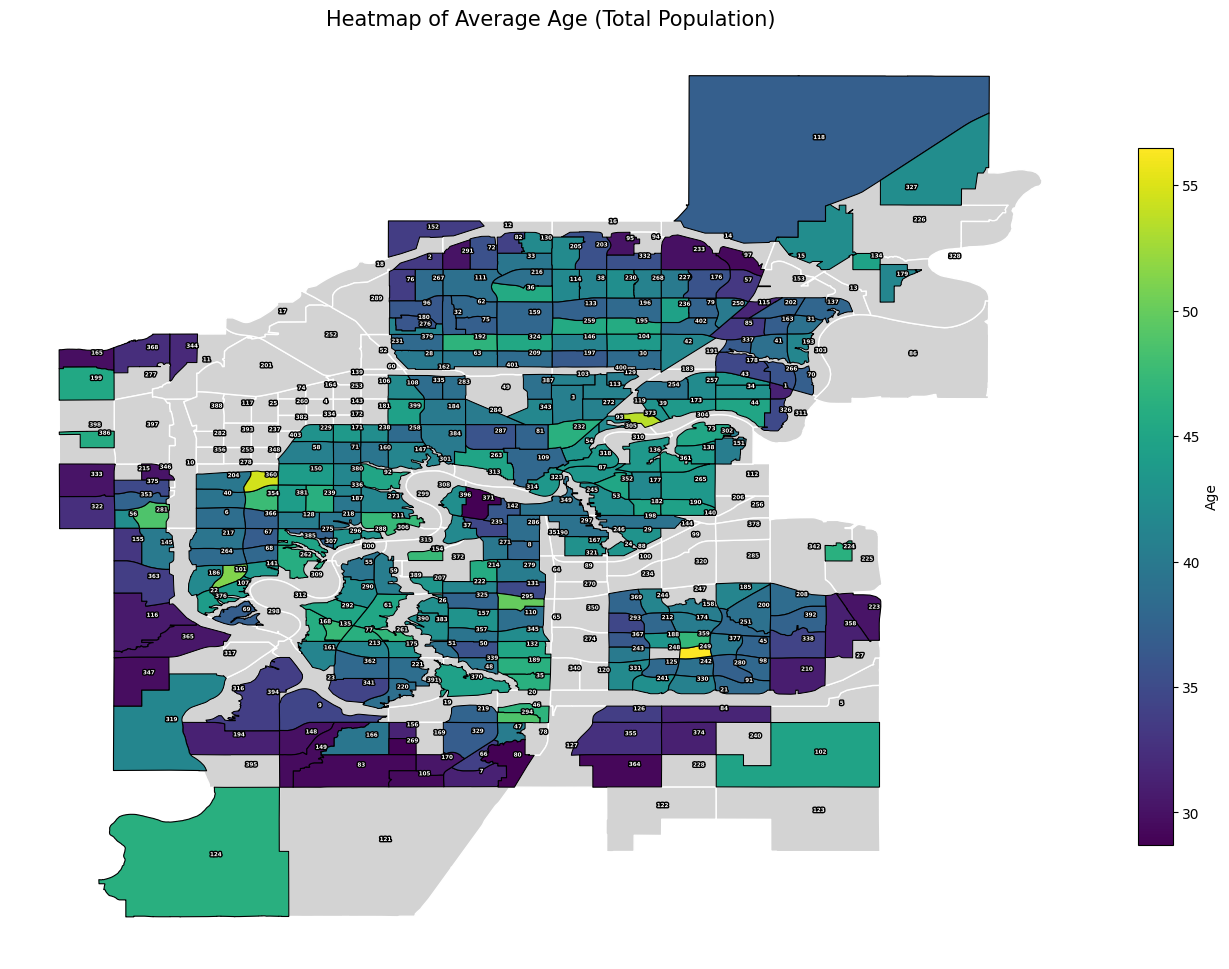

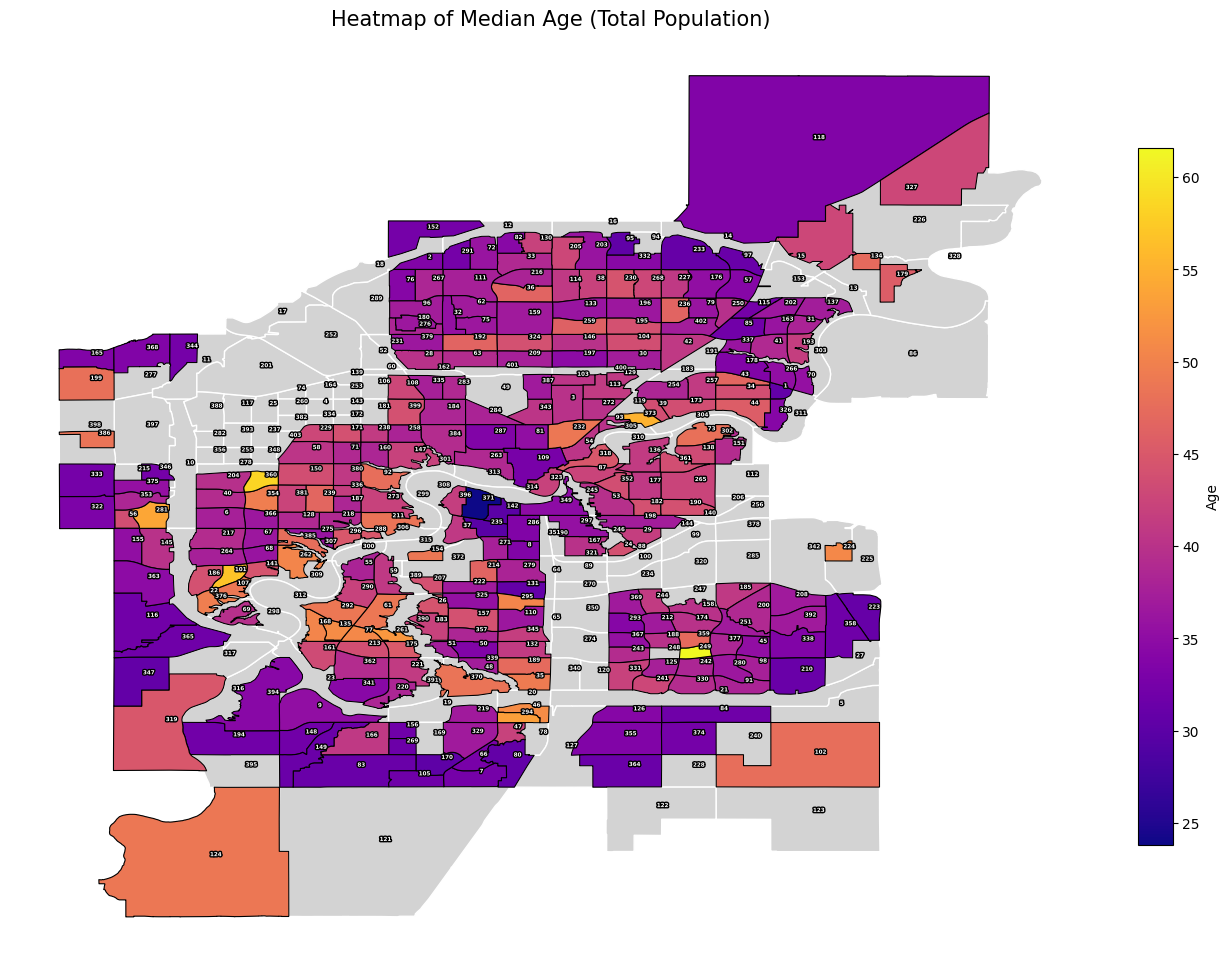

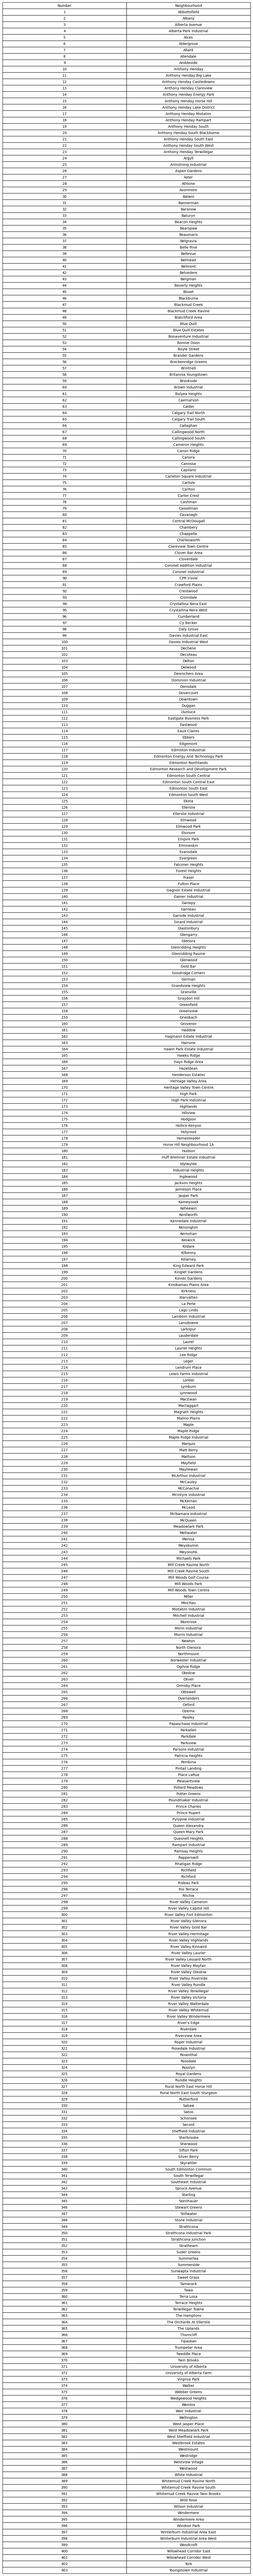

In [284]:
# Create a heatmap with numbers for the Average Age of the Population
create_heatmap(gdf, avg_age_gdf, 'Heatmap of Average Age (Total Population)', 'Value', cmap='viridis')

# Create a heatmap with numbers for the median Age of the Population
create_heatmap(gdf, median_age_gdf, 'Heatmap of Median Age (Total Population)', 'Value', cmap='plasma')

# generate TOC 
create_toc_plot(gdf)

## Conclusion
The map's depiction of the lower average age in the city's outskirts points to a tendency of younger people living there. There are a number of reasons for this tendency, including the availability of inexpensive housing alternatives that appeal to young families, the existence of educational institutions, or the introduction of new development initiatives targeted at younger populations. As a result, there may be an increase in demand for services in these locations that cater to young families, like daycare centers, schools, and recreational parks. For urban planners and policymakers to guarantee that the infrastructure and services are in line with the needs of these developing communities and promote an atmosphere that is conducive to their growth and sustainability, they must have a thorough understanding of this demographic trend.